In [1]:
import os
os.chdir('../..')


In [2]:
from classes.helpers import *
import numpy as np
import json
import pandas as pd
import scipy.stats as ss
from sklearn import linear_model
import ast
import scipy.stats as ss


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

from scipy.optimize import minimize

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

data_folder = '../data/'
save_folder = '../figures/all/4-herding/'

colors = {'H for HH': '#8b0000',
          'H for HL': '#c1253d',
          'H for HM': '#e75c59',
          'M for HM': '#fe9755',
          'M for MM': '#ffd700',
          'M for LM': '#9dcd75',
          'L for LM': '#6cb482',
          'L for HL': '#419a83',
          'L for LL': '#008080',
          'ba': (232/255,164/255,29/255), 
          'rb': (0/255,152/255,205/255)}



type_ = 'global'
#type_ = 'product'
#type_ = 'rank'

if type_ == 'product':
    min_nbr_rats = 10
else:
    min_nbr_rats = 5



## Load Time Series DF with ranks

In [3]:
df = pd.read_csv(data_folder + 'tmp/time_series_{}_ranks.csv'.format(min_nbr_rats), header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores', 'ranks']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)

In [4]:
diffs = {'ba': [], 'rb': []}

for key in diffs.keys():
    for i in df.index:
        row = df.iloc[i]
        if type_ == 'product':
            diffs[key].append(row[key]['z_scores'][0] - np.mean(row[key]['z_scores']))
        else:
            diffs[key].append(row[key]['z_scores'][0])

thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

## Classify ratings (check)

In [5]:
classes = {}

for i in df.index:    
    ba = diffs['ba'][i]
    rb = diffs['rb'][i]


    if ba > thresholds['ba']['high']:
        class_ = 'H'
    elif ba >= thresholds['ba']['low']:
        class_ = 'M'
    else:
        class_ = 'L'

    class_ += '-'

    if rb > thresholds['rb']['high']:
        class_ += 'H'
    elif rb >= thresholds['rb']['low']:
        class_ += 'M'
    else:
        class_ += 'L' 

    if class_ not in classes.keys():
        classes[class_] = 0

    classes[class_] += 1

In [6]:
print(classes)

{'M-M': 6593, 'H-M': 1210, 'L-M': 1242, 'M-H': 1213, 'H-L': 138, 'M-L': 1225, 'L-L': 568, 'L-H': 116, 'H-H': 585}


## Histogram 1D

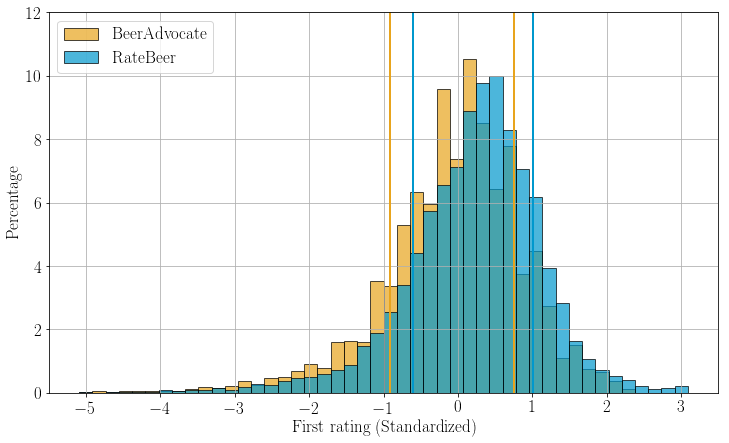

In [7]:
labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in labels.keys():
    a, bin_edges[key] = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins)
    hist[key], a = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100

plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, facecolor=colors[key], edgecolor='k', alpha=0.7, label=labels[key])

if type_ == 'product':
    max_ = 14
else:
    max_ = 12

plt.grid()
plt.legend(loc=2)
plt.ylim([0, max_])

for key in labels.keys():        
    plt.plot([thresholds[key]['low'], thresholds[key]['low']], [0, max_], color=colors[key], linewidth=2)
    plt.plot([thresholds[key]['high'], thresholds[key]['high']], [0, max_], color=colors[key], linewidth=2)

plt.ylabel('Percentage')

if type_ == 'product':
    plt.xlabel('Difference between first rating and average (Standardized)')
else:
    plt.xlabel('First rating (Standardized)')
if type_ != 'rank':
    plt.savefig(save_folder + 'hist_first_rat_{}.pdf'.format(type_), bbox_inches='tight')

## Bootstrap

In [18]:
np.random.seed(10)

classes_to_study = ['HH', 'LL', 'MM', 'LM', 'HL', 'HM']

nbr_draws = 10000

vals = {}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for ' + cl, cl[-1] + ' for ' + cl]
                
        subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)] 
        
        for class_ in classes:
            vals[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            ba = subdf[subdf['ba']['class'] == letter]['ba']
            ba.index = range(len(ba))
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            rb.index = range(len(rb))
            
            nbr = min(len(ba), len(rb))
            
            ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
            ba.index = range(len(ba))
            
            rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
            rb.index = range(len(rb))
        
            # Go through all the ratings
            for i in range(min_nbr_rats):
                
                if type_ == 'rank':
                    vals_ba = np.array([r[i] for r in ba['ranks']])
                    vals_rb = np.array([r[i] for r in rb['ranks']])
                elif type_ == 'global':
                    vals_ba = np.array([r[i] for r in ba['z_scores']])
                    vals_rb = np.array([r[i] for r in rb['z_scores']])
                elif type_ == 'product':
                    vals_ba = np.array([r[i]-np.mean(r) for r in ba['z_scores']])
                    vals_rb = np.array([r[i]-np.mean(r) for r in rb['z_scores']])
                
                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    vals_tmp = vals_ba[idx_ba]
                    vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])
                                        
                    tmp.append(np.mean(vals_tmp))
                    
                avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
                vals[class_]['avg'].append(avg)
                vals[class_]['low'].append(np.percentile(tmp, 2.5))
                vals[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for ' + cl
        vals[class_] = {'avg': [], 'low': [], 'high': []}
        
        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)]

        # Go through all the ratings
        for i in range(min_nbr_rats):
             
            if type_ == 'rank':
                vals_both = np.array([r[i] for r in subdf['ba']['ranks']])
                vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['ranks']]))
            elif type_ == 'global':
                vals_both = np.array([r[i] for r in subdf['ba']['z_scores']])
                vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['z_scores']]))
            elif type_ == 'product':
                vals_both = np.array([r[i]-np.mean(r) for r in subdf['ba']['z_scores']])
                vals_both = np.append(vals_both, np.array([r[i]-np.mean(r) for r in subdf['rb']['z_scores']]))
                             
            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(vals_both), len(vals_both))
                
                vals_tmp = vals_both[indices]
                
                tmp.append(np.mean(vals_tmp))
            
            vals[class_]['avg'].append(np.mean(vals_both))
            vals[class_]['low'].append(np.percentile(tmp, 2.5))
            vals[class_]['high'].append(np.percentile(tmp, 97.5))

In [20]:
with open(data_folder + 'plot/herding.json', 'w') as outfile:
    json.dump(vals, outfile)

## Plot Herding

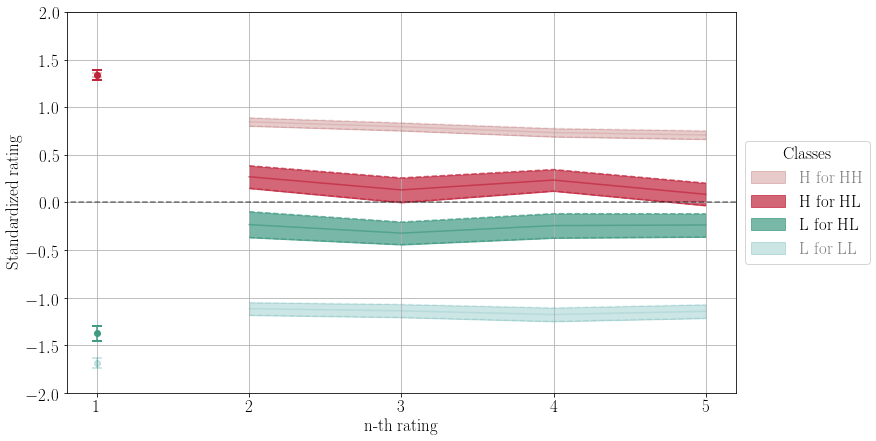

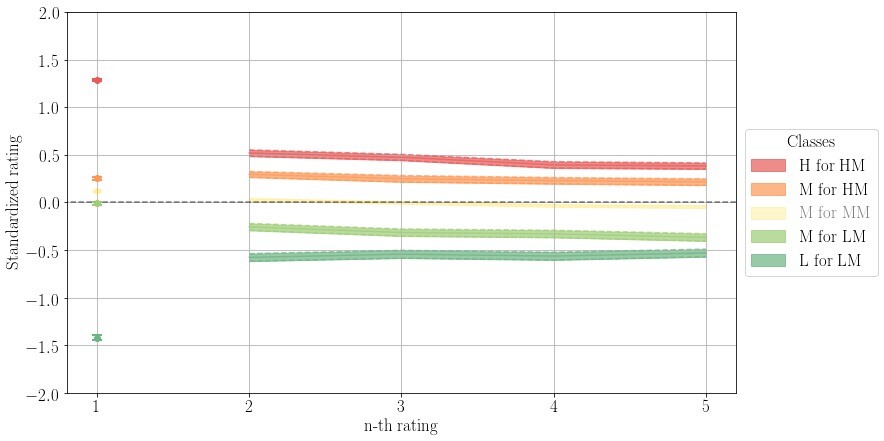

In [19]:
for type_class in ['extreme', 'medium']:

    plt.figure(figsize=(12, 7))
    plt.grid()

    plt.rc('font', family='serif')
    plt.rc('font', size=17)

    ax = plt.subplot(111)

    if type_class == 'extreme':
        classes_to_plot = ['H for HH','H for HL', 'L for HL', 'L for LL']

        vals_class = [0, 3]

    elif type_class == 'medium':  
        classes_to_plot = ['H for HM', 'M for HM', 'M for MM', 'M for LM', 'L for LM']

        vals_class = [2]

    i = 0
    for class_ in classes_to_plot:

        vals_tmp = vals[class_]

        avg = np.array(vals_tmp['avg'])
        high = np.array(vals_tmp['high'])
        low = np.array(vals_tmp['low'])

        if i in vals_class:
            alpha = 0.2
        else:
            alpha = 1

        plt.errorbar(1, avg[0], yerr=[[high[0]-avg[0]], [avg[0]-low[0]]],
                    fmt='o', capsize=5, capthick=2, c=colors[class_], alpha=alpha)

        avg = avg[1:]
        high = high[1:]
        low = low[1:]

        if i in vals_class:
            alpha = 0.1
        else:
            alpha = 0.7

        plt.plot(range(2, min_nbr_rats + 1), avg, color=colors[class_], alpha=alpha)
        plt.plot(range(2, min_nbr_rats + 1), high, '--', color=colors[class_], alpha=alpha)
        plt.plot(range(2, min_nbr_rats + 1), low, '--', color=colors[class_], alpha=alpha)

        if i in vals_class:
            alpha = 0.2
        else:
            alpha = 0.7
        plt.fill_between(range(2, min_nbr_rats + 1), low, high, color=colors[class_], alpha=alpha, label = class_) 

        i+=1

    l = plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(list(range(1,min_nbr_rats + 1)))

    i = 0
    for text in l.get_texts():
        if i in vals_class:
            text.set_color('gray')
        i+=1
        
    if type_ == 'rank':
        plt.plot([-2, min_nbr_rats + 2], [0.5, 0.5], '--k', alpha=0.5)

        plt.ylim([0, 1])
        yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        plt.yticks(yticks, yticks)
        plt.ylabel('Normalized Rank')

    elif type_ == 'global':
        plt.plot([-2, min_nbr_rats + 2], [0, 0], '--k', alpha=0.5)

        plt.ylim([-2, 2])
        plt.ylabel('Standardized rating')
        
    elif type_ == 'product':
        plt.plot([-2, min_nbr_rats + 2], [0, 0], '--k', alpha=0.5)
        
        plt.ylim([-1.5, 1.5])
        plt.ylabel('$\Delta$ standardized rating and average standardized rating')


    plt.xlim([0.8, min_nbr_rats + 0.2])

    plt.xlabel('n-th rating')

    #plt.savefig(save_folder + 'herding_{}_{}.pdf'.format(type_class, type_), bbox_inches='tight')

# Long term average

In [7]:
if type_ != 'product':
    classes_to_study = ['HH', 'HL', 'LL', 'HM', 'MM', 'LM']

    np.random.seed(10)

    nbr_draws = 10000

    min_nbr_ratings = 20

    classes_names = []
    vals_lta = {'avg': [], 'low': [], 'high': []}

    # Go through all the classes
    for cl in classes_to_study:

        if cl[0] != cl[-1]:
            # Take care of first class

            if cl == 'LM':
                classes = [cl[-1] + ' for ' + cl, cl[0] + ' for ' + cl]
            else:
                classes = [cl[0] + ' for ' + cl, cl[-1] + ' for ' + cl]

            subdf = df[((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                       ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))] 
            subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

            for class_ in classes:
                classes_names.append(class_)

                letter = class_[0]

                ba = subdf[subdf['ba']['class'] == letter]['ba']
                ba.index = range(len(ba))
                rb = subdf[subdf['rb']['class'] == letter]['rb']
                rb.index = range(len(rb))

                nbr = min(len(ba), len(rb))

                ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
                ba.index = range(len(ba))

                rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
                rb.index = range(len(rb))

                if type_ == 'rank':
                    vals_ba = np.array(ba['rank_avg'])
                    vals_rb = np.array(rb['rank_avg'])
                elif type_ == 'global':
                    vals_ba = np.array(ba['avg_z_scores'])
                    vals_rb = np.array(rb['avg_z_scores'])

                tmp = []
                # Go through each draw
                for d in range(nbr_draws):

                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)

                    vals_tmp = vals_ba[idx_ba]
                    vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])

                    tmp.append(np.mean(vals_tmp))

                avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
                vals_lta['avg'].append(avg)
                vals_lta['low'].append(np.percentile(tmp, 2.5))
                vals_lta['high'].append(np.percentile(tmp, 97.5))            

        else:

            class_ = cl[0] + ' for ' + cl
            classes_names.append(class_)

            subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0])]

            subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

            if type_ == 'rank':
                vals_both = np.array(subdf['ba']['rank_avg'])
                vals_both = np.append(vals_both, np.array(subdf['rb']['rank_avg']))
            elif type_ == 'global':
                vals_both = np.array(subdf['ba']['avg_z_scores'])
                vals_both = np.append(vals_both, np.array(subdf['rb']['avg_z_scores']))

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):

                indices = np.random.randint(0, len(vals_both), len(vals_both))

                vals_tmp = vals_both[indices]

                tmp.append(np.mean(vals_tmp))

            vals_lta['avg'].append(np.mean(vals_both))
            vals_lta['low'].append(np.percentile(tmp, 2.5))
            vals_lta['high'].append(np.percentile(tmp, 97.5))  

In [10]:
classes_names

['H for HH',
 'H for HL',
 'L for HL',
 'L for LL',
 'H for HM',
 'M for HM',
 'M for MM',
 'M for LM',
 'L for LM']

In [9]:
with open(data_folder + 'plot/herding_lta.json', 'w') as outfile:
    json.dump(vals_lta, outfile)

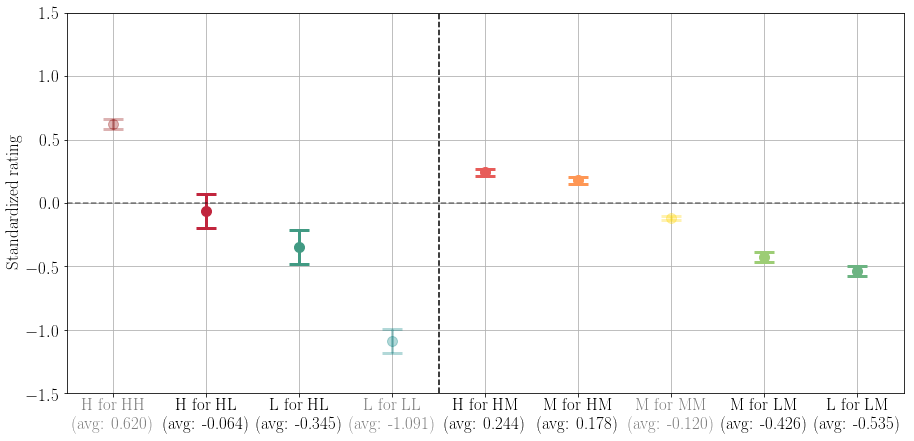

In [15]:
if type_ != 'product':
    plt.figure(figsize=(15, 7))
    plt.grid()

    plt.rc('font', family='serif')
    plt.rc('font', size=17)

    ax = plt.subplot(111)

    vals_class = [0, 3, 6]

    avg = np.array(vals_lta['avg'])
    low = np.array(vals_lta['low'])
    high = np.array(vals_lta['high'])

    text_ticks = []
    for i in range(len(avg)):

        if i in vals_class:
            alpha = 0.3
        else:
            alpha = 1

        plt.errorbar(i, avg[i], yerr=[[high[i]-avg[i]], [avg[i]-low[i]]], 
                    fmt='o', markersize=10, capsize=10, capthick=3, lw=3,
                     c=colors[classes_names[i]], alpha=alpha)

        text_ticks.append(classes_names[i] + '\n(avg: {:.3f})'.format(avg[i]))

    plt.xlim([-0.5, len(text_ticks)-0.5])
    plt.xticks(list(range(len(text_ticks))), text_ticks)

    i=0
    for xtick in ax.xaxis.get_ticklabels():

        if i in vals_class:
            xtick.set(color='gray')

        i+=1

    if type_ == 'rank':
        plt.plot([-0.5, len(text_ticks)-0.5], [0.5, 0.5], '--k', alpha=0.5)
        plt.plot([3.5, 3.5], [0, 1], 'k--')

        plt.ylim([0, 1])
        yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        plt.yticks(yticks, yticks)
        plt.ylabel('Normalized Rank')

    elif type_ == 'global':
        plt.plot([-0.5, len(text_ticks)-0.5], [0, 0], '--k', alpha=0.5)
        plt.plot([3.5, 3.5], [-1.5, 1.5], 'k--')

        plt.ylim([-1.5, 1.5])
        plt.ylabel('Standardized rating')

    #plt.savefig(save_folder + 'lta_herding_{}.pdf'.format(type_), bbox_inches='tight')

## Herding with varying number of beers

In [14]:
df = pd.read_csv(data_folder + 'tmp/time_series_{}_ranks.csv'.format(min_nbr_rats), header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores', 'ranks']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)
            
diffs = {'ba': [], 'rb': []}

for key in diffs.keys():
    for i in df.index:
        row = df.iloc[i]
        if type_ == 'product':
            diffs[key].append(row[key]['z_scores'][0] - np.mean(row[key]['z_scores']))
        else:
            diffs[key].append(row[key]['z_scores'][0])

thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

In [15]:
classes_to_study = ['H-H', 'L-L', 'M-M', 'L-M', 'H-L', 'H-M']

np.random.seed(1)

nbr_draws = 1000

if type_ == 'product':
    nbr_ratings = 20
else:
    nbr_ratings = 10

vals = {}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']

        for class_ in classes:
            vals[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            # Go through all the ratings
            for i in range(nbr_ratings):
                                
                subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                           ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                           (df['ba']['nbr_ratings'] >= i+1) & (df['rb']['nbr_ratings'] >= i+1)] 
                
                ba = subdf[subdf['ba']['class'] == letter]['ba']
                ba.index = range(len(ba))
                rb = subdf[subdf['rb']['class'] == letter]['rb']
                rb.index = range(len(rb))

                nbr = min(len(ba), len(rb))

                ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
                ba.index = range(len(ba))

                rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
                rb.index = range(len(rb))
                
                if type_ == 'rank':
                    vals_ba = np.array([r[i] for r in ba['ranks']])
                    vals_rb = np.array([r[i] for r in rb['ranks']])
                if type_ == 'global':
                    vals_ba = np.array([r[i] for r in ba['z_scores']])
                    vals_rb = np.array([r[i] for r in rb['z_scores']])
                if type_ == 'product':
                    vals_ba = np.array([r[i]-np.mean(r) for r in ba['z_scores']])
                    vals_rb = np.array([r[i]-np.mean(r) for r in rb['z_scores']])
                    
                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    vals_tmp = vals_ba[idx_ba]
                    vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])
                                        
                    tmp.append(np.mean(vals_tmp))
                    
                avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
                vals[class_]['avg'].append(avg)
                vals[class_]['low'].append(np.percentile(tmp, 2.5))
                vals[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for (' + cl + ')'
        vals[class_] = {'avg': [], 'low': [], 'high': []}
        
        # Go through all the ratings
        for i in range(nbr_ratings):
            
            subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                       (df['ba']['nbr_ratings'] >= i+1) & (df['rb']['nbr_ratings'] >= i+1)]
             
            if type_ == 'rank':
                vals_both = np.array([r[i] for r in subdf['ba']['ranks']])
                vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['ranks']]))
            if type_ == 'global':
                vals_both = np.array([r[i] for r in subdf['ba']['z_scores']])
                vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['z_scores']]))
            if type_ == 'product':
                vals_both = np.array([r[i]-np.mean(r) for r in subdf['ba']['z_scores']])
                vals_both = np.append(vals_both, np.array([r[i]-np.mean(r) for r in subdf['rb']['z_scores']]))

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(vals_both), len(vals_both))
                
                vals_tmp = vals_both[indices]
                
                tmp.append(np.mean(vals_tmp))
            
            vals[class_]['avg'].append(np.mean(vals_both))
            vals[class_]['low'].append(np.percentile(tmp, 2.5))
            vals[class_]['high'].append(np.percentile(tmp, 97.5))

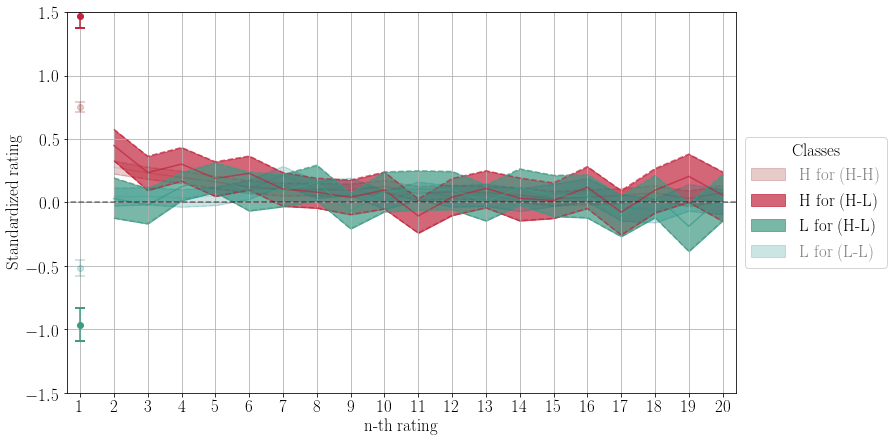

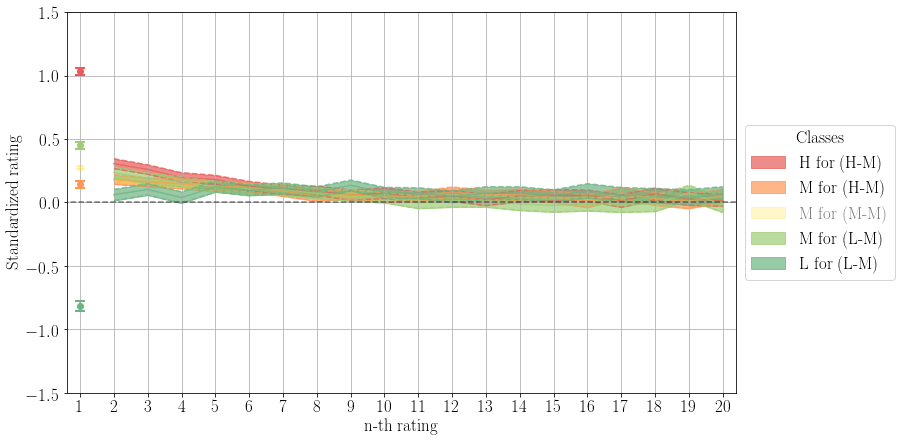

In [17]:
for type_class in ['extreme', 'medium']:

    plt.figure(figsize=(12, 7))
    plt.grid()

    plt.rc('font', family='serif')
    plt.rc('font', size=17)

    ax = plt.subplot(111)

    if type_class == 'extreme':
        classes_to_plot = ['H for (H-H)','H for (H-L)', 'L for (H-L)', 'L for (L-L)']

        vals_class = [0, 3]

    elif type_class == 'medium':  
        classes_to_plot = ['H for (H-M)', 'M for (H-M)', 'M for (M-M)', 'M for (L-M)', 'L for (L-M)']

        vals_class = [2]

    i = 0
    for class_ in classes_to_plot:

        vals_tmp = vals[class_]

        avg = np.array(vals_tmp['avg'])
        high = np.array(vals_tmp['high'])
        low = np.array(vals_tmp['low'])

        if i in vals_class:
            alpha = 0.2
        else:
            alpha = 1

        plt.errorbar(1, avg[0], yerr=[[high[0]-avg[0]], [avg[0]-low[0]]],
                    fmt='o', capsize=5, capthick=2, c=colors[class_], alpha=alpha)

        avg = avg[1:]
        high = high[1:]
        low = low[1:]

        if i in vals_class:
            alpha = 0.1
        else:
            alpha = 0.7

        plt.plot(range(2, nbr_ratings + 1), avg, color=colors[class_], alpha=alpha)
        plt.plot(range(2, nbr_ratings + 1), high, '--', color=colors[class_], alpha=alpha)
        plt.plot(range(2, nbr_ratings + 1), low, '--', color=colors[class_], alpha=alpha)

        if i in vals_class:
            alpha = 0.2
        else:
            alpha = 0.7
        plt.fill_between(range(2, nbr_ratings + 1), low, high, color=colors[class_], alpha=alpha, label = class_) 

        i+=1

    l = plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
    if nbr_ratings <= 20:
        plt.xticks(list(range(1, nbr_ratings + 1)))
    elif nbr_ratings <= 50:
        plt.xticks(list(range(0, nbr_ratings + 1, 2)))
    else:
        plt.xticks(list(range(0, nbr_ratings + 1, 5)))

    i = 0
    for text in l.get_texts():
        if i in vals_class:
            text.set_color('gray')
        i+=1
        
    if type_ == 'rank':
        plt.plot([-2, nbr_ratings + 2], [0.5, 0.5], '--k', alpha=0.5)

        plt.ylim([0, 1])
        yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        plt.yticks(yticks, yticks)
        plt.ylabel('Normalized Rank')

    elif type_ == 'global':
        plt.plot([-2, nbr_ratings + 2], [0, 0], '--k', alpha=0.5)

        plt.ylim([-2, 2])
        plt.ylabel('Standardized rating')
        
    elif type_ == 'product':
        plt.plot([-2, nbr_ratings + 2], [0, 0], '--k', alpha=0.5)

        plt.ylim([-1.5, 1.5])
        plt.ylabel('Standardized rating')

    plt.xlim([0.6, nbr_ratings + 0.4])
    
    plt.xlabel('n-th rating')

    plt.savefig(save_folder + 'herding_varying_{}_{}.pdf'.format(type_class, type_), bbox_inches='tight')